## Source of Data

Data used in this notebook are provided from [Download zipfile of CSV files for ArcGIS Online](https://witches.is.ed.ac.uk/resources/ArcGIS%20Online%20Files.zip) in https://witches.is.ed.ac.uk/resources/.

All data seems to be extracted from Wikidata and saved as CSV files. 

Although the original data in wikidata are saved in json-like format(e.g. [Witch Violet Mar](https://www.wikidata.org/wiki/Q43393985)), they can be converted into 2D list by using "SELECT" in queries.


## Data Description

First of all, read all .csv files and check structures:

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


folder_path = '..\ArcGIS Online Files'
all_csv = []
all_column_names = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and file_name.startswith('Accused'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        first_row = df.iloc[0]
        all_csv.append(df)
        all_column_names.extend(df.columns)
merged_df = pd.concat(all_csv, ignore_index=True)

Check what attribute they have:

In [2]:
print(set(all_column_names))
print('===========================')
merged_df.info()

{'Name', 'Residence', 'Social Classification', 'Wikidata Page', 'Occupation', 'Longitude', 'Manner of Death', 'Ethnicity', 'Gender', 'Place of Detainment', 'Place of Death', 'Wikipedia Page', 'Latitude'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3185 entries, 0 to 3184
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Wikidata Page          3185 non-null   object 
 1   Name                   3185 non-null   object 
 2   Residence              3185 non-null   object 
 3   Longitude              3185 non-null   float64
 4   Latitude               3185 non-null   float64
 5   Gender                 3168 non-null   object 
 6   Ethnicity              11 non-null     object 
 7   Manner of Death        274 non-null    object 
 8   Occupation             121 non-null    object 
 9   Place of Detainment    506 non-null    object 
 10  Social Classification  357 non-null    object 
 11  Wikipedi

From above, in 3185 entries of data, all of these data have Wikidata Page, Name, Residence, Longitude and Latitude, but very few data have Ethnicity, Occupation and so on. However, these columns still worth analysis.

Most of those are textual data representing Name, Gender, Manner of Death etc. And a few in time format

## Fetch Extra Data

### Use API

By checking Wikidata page we found almost every witch page contains a significant event: Witchcraft Investigation, which has variously time point such as "start time",  "end time" and all of them have "point of time". This term indicates that might be not so accurate for the time but in the view of the ancient year and a long timescale that is enough for analysis.

In [3]:
# Reference: https://itnext.io/extracting-data-from-wikidata-using-sparql-and-python-59e0037996f

import sys
import pandas as pd
from typing import List, Dict
from SPARQLWrapper import SPARQLWrapper, JSON

class WikiDataQueryResults:
    """
    A class that can be used to query data from Wikidata using SPARQL and return the results as a Pandas DataFrame or a list
    of values for a specific key.
    """
    def __init__(self, query: str):
        """
        Initializes the WikiDataQueryResults object with a SPARQL query string.

        :param query: A SPARQL query string.
        """
        self.user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
        self.endpoint_url = "https://query.wikidata.org/sparql"
        self.sparql = SPARQLWrapper(self.endpoint_url, agent=self.user_agent)
        self.sparql.setQuery(query)
        self.sparql.setReturnFormat(JSON)

    def __transform2dicts(self, results: List[Dict]) -> List[Dict]:
        """
        Helper function to transform SPARQL query results into a list of dictionaries.

        :param results: A list of query results returned by SPARQLWrapper.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        new_results = []
        for result in results:
            new_result = {}
            for key in result:
                new_result[key] = result[key]['value']
            new_results.append(new_result)
        return new_results

    def _load(self) -> List[Dict]:
        """
        Helper function that loads the data from Wikidata using the SPARQLWrapper library, and transforms the results into
        a list of dictionaries.

        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        results = self.sparql.queryAndConvert()['results']['bindings']
        results = self.__transform2dicts(results)
        return results

    def load_as_dataframe(self) -> pd.DataFrame:
        """
        Executes the SPARQL query and returns the results as a Pandas DataFrame.

        :return: A Pandas DataFrame representing the query results.
        """
        results = self._load()
        return pd.DataFrame.from_dict(results)

Then I can use Wikidata API to request data list from the site.

I learnt SPARQL to form the query:

In [4]:
query ="""
SELECT DISTINCT ?item ?point_of_time 
WHERE {
  ?item p:P4478 ?statement0.
  ?statement0 (ps:P4478) _:anyValueP4478.    
  ?item p:P793 ?statement1.
  ?statement1 (ps:P793) wd:Q66458810.
  ?statement1 pq:P585 ?point_of_time.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
"""

data_extracter = WikiDataQueryResults(query)
extra_df = data_extracter.load_as_dataframe()

extra_df

,item,point_of_time
0,http://www.wikidata.org/entity/Q43396006,1603-08-02T00:00:00Z
1,http://www.wikidata.org/entity/Q43396091,1602-01-17T00:00:00Z
2,http://www.wikidata.org/entity/Q43395927,1591-05-18T00:00:00Z
3,http://www.wikidata.org/entity/Q43395911,1591-01-05T00:00:00Z
4,http://www.wikidata.org/entity/Q43396072,1586-05-19T00:00:00Z
...,...,...
3192,http://www.wikidata.org/entity/Q43395296,1615-08-19T00:00:00Z
3193,http://www.wikidata.org/entity/Q43395287,1613-12-11T00:00:00Z
3194,http://www.wikidata.org/entity/Q43395204,1611-06-11T00:00:00Z
3195,http://www.wikidata.org/entity/Q43396079,1610-08-27T00:00:00Z


There are 3197 rows of data, close to those data merged from CSV files.

This can be also merged in to the previous merged dataframe by using address as the key. 

In [5]:
extended_df = merged_df.merge(extra_df,left_on='Wikidata Page',right_on='item').drop(['item'], axis=1)
extended_df.head()

,Wikidata Page,Name,Residence,Longitude,Latitude,Gender,Ethnicity,Manner of Death,Occupation,Place of Detainment,Social Classification,Wikipedia Page,Place of Death,point_of_time
0,http://www.wikidata.org/entity/Q43390211,Jonnet McKennan,Balmurrie,-4.805504,54.959995,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1644-09-28T00:00:00Z
1,http://www.wikidata.org/entity/Q43390291,Jonet Braidheid,Balmakeith,-3.852752,57.580476,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1662-04-24T00:00:00Z
2,http://www.wikidata.org/entity/Q43390319,Wife of Soirle McAllexander,Isle of Bute,-5.056360,55.835690,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1662-02-08T00:00:00Z
3,http://www.wikidata.org/entity/Q43390500,Christian Watson,North Berwick,-2.717000,56.058000,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663-10-26T00:00:00Z
4,http://www.wikidata.org/entity/Q43390507,Janet Conochie,Bo'ness,-3.608911,56.016811,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1670-01-01T00:00:00Z


Thus, we have the extended dataframe. The size of this is slightly smaller than the previous two. (From 3197 and 3185 rows to 3154 rows.) This can be ignored at this point.

### Convert Time

For time data, Pandas use timestamp. However, the limitations are '1677-09-21 00:12:43.145224193' and '2262-04-11 23:47:16.854775807'.

Unfortunately, witches' time was a little out of bound, so we have to use Period to represent the time: 

In [6]:
def conv(x):
    if type(x) is str:
        t = x[:10]
        return pd.Period(year=int(t[0:4]),
                         month=int(t[5:7]),
                         day=int(t[8:10]),
                         freq="D")
    elif type(x) is pd.Period:
        # print('already Period')
        return x
    else:
        raise TypeError('x need to be string')
    
extended_df['point_of_time'].apply(conv)

0       1644-09-28
1       1662-04-24
2       1662-02-08
3       1663-10-26
4       1670-01-01
           ...    
3149    1669-11-21
3150    1650-06-29
3151    1628-12-05
3152    1697-03-29
3153    1697-01-29
Name: point_of_time, Length: 3154, dtype: period[D]

In [7]:
df = extended_df.copy()
df['point_of_time']= pd.PeriodIndex(extended_df['point_of_time'].apply(conv))
df['year']= df['point_of_time'].apply(lambda x:x.year)

Nicely converted, year is enough for macro analysis.

## Detailed Insight

A deeper exploration of the data

Point of time, Occupation, Social Classification, Place of Detainment, Place of Death and Gender will be explored.

### Time

Check the latest and the earliest year accuse happened:

In [8]:
print(df['point_of_time'].max())
print(df['point_of_time'].min())

1727-06-01
1562-02-21


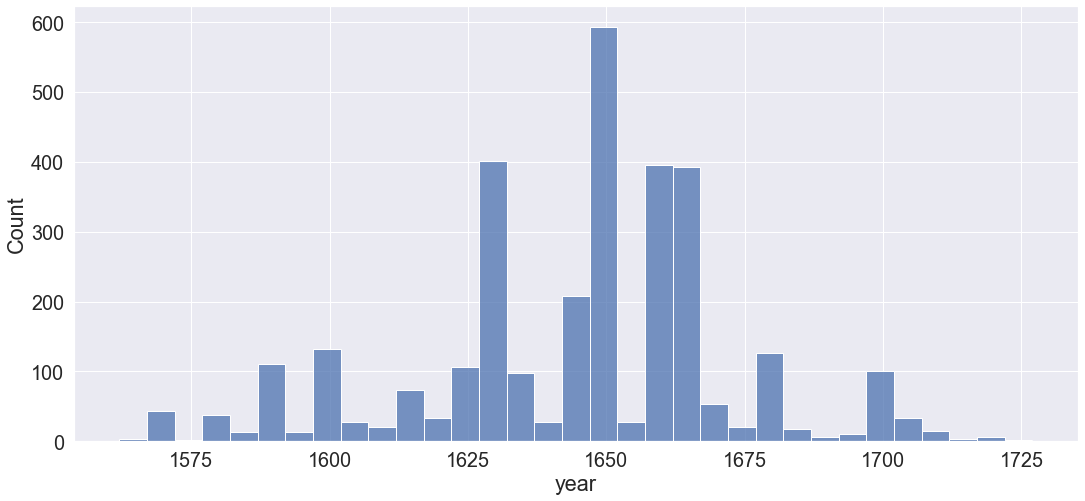

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.8)

plt.figure(figsize=(18,8))
ax = sns.histplot(data=df['year'],binwidth=5)
plt.show()

In every 5 years we can see around 1650 the hunt reached the peak. 

Hard to say there is a trend, but it seemed to be a rise and fall progress.

### Gender

Check the value counts first:

In [10]:
df['Gender'].value_counts()

Female    2688
Male       449
Name: Gender, dtype: int64

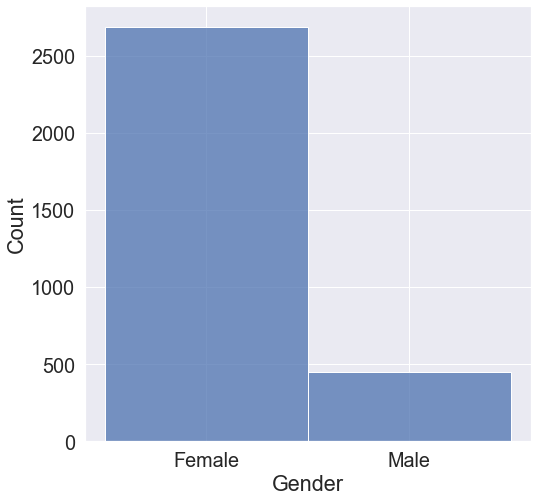

In [11]:
plt.figure(figsize=(8,8))
ax = sns.histplot(data=df['Gender'])
plt.show()

In [12]:
df['Gender'].value_counts(normalize=True)

Female    0.85687
Male      0.14313
Name: Gender, dtype: float64

Surprisingly, up to 14.3% accused witches were male. Isn't witch a word to describe female? What is wizard then? 

### Occupation

In [13]:
data = df['Occupation'].value_counts()

In those recorded, the majorities were vagrant and domestic worker.

([<matplotlib.patches.Wedge at 0x18a71a93d00>,
 [Text(0.708301456776909, 0.8416109827751231, 'Vagrant'),
  Text(-0.8864925113266104, 0.6512534279079379, 'Domestic Worker'),
  Text(-0.9910657116031256, -0.4772722025056461, 'Midwife'),
  Text(-0.6156469959769342, -0.9115803729483084, 'Weaver'),
  Text(-0.3564464041953762, -1.040646895414668, ''),
  Text(-0.24477289377441164, -1.072420733888198, ''),
  Text(-0.13037238073378196, -1.0922467863728444, ''),
  Text(-0.014519395492040576, -1.0999041718052285, ''),
  Text(0.10149534961180075, -1.095307579635592, ''),
  Text(0.2163793400801623, -1.0785082202683824, ''),
  Text(0.3288526590965459, -1.0496932545296893, ''),
  Text(0.43766224701504547, -1.0091837085178008, ''),
  Text(0.5415958616354629, -0.9574308970674285, ''),
  Text(0.639495583733284, -0.895011395673612, ''),
  Text(0.7083016365332496, -0.8416108314918008, ''),
  Text(0.7517308606359842, -0.8030571045495348, ''),
  Text(0.7930648757873903, -0.7622651131937835, ''),
  Text(0.832

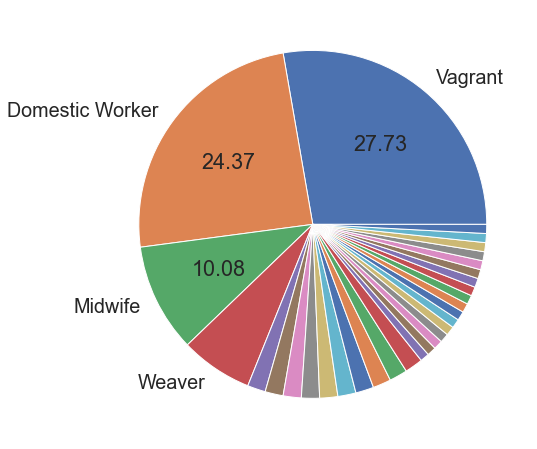

In [14]:
plt.figure(figsize=(8,8))

omit_num = 27
labels = list(data.index)[:-omit_num]+['']*omit_num
plt.pie(data,labels=labels,autopct=lambda x:('%.2f' % x) if x > 10 else '')

### Social Classification

In [15]:
data = df['Social Classification'].value_counts()
print(data.sum())
data

353


Middling        232
Working Poor     72
Pauper           19
Upper Class      16
Vagrant           6
Laird             4
Nobility          4
Name: Social Classification, dtype: int64

['Middling', 'Working Poor', 'Pauper', 'Upper Class', '', '', '']


([<matplotlib.patches.Wedge at 0x18a71cb83a0>,
 [Text(-0.5215018936100936, 0.9685224700341685, 'Middling'),
  Text(0.06359751500776907, -1.0981599865615377, 'Working Poor'),
  Text(0.8391427829619745, -0.7112238675711274, 'Pauper'),
  Text(1.0167352132994136, -0.41982080229187774, 'Upper Class'),
  Text(1.0789830408513472, -0.21399905970629873, ''),
  Text(1.093732974646856, -0.11725263395821794, ''),
  Text(1.0993030792126928, -0.039150223926462946, '')],
 [Text(-0.2844555783327783, 0.5282849836550009, '65.72'),
  Text(0.034689553640601306, -0.5989963563062932, '20.40'),
  Text(0.45771424525198606, -0.3879402914024331, ''),
  Text(0.5545828436178619, -0.22899316488647875, ''),
  Text(0.5885362041007348, -0.1167267598397993, ''),
  Text(0.5965816225346487, -0.06395598215902797, ''),
  Text(0.5996198613887415, -0.021354667596252513, '')])

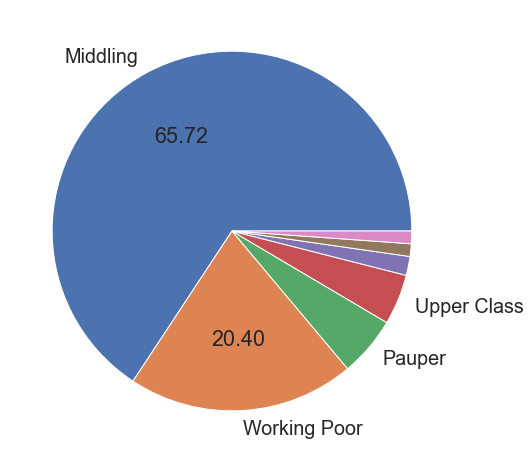

In [16]:
omit_num = 3
labels = list(data.index)[:-omit_num]+['']*omit_num
print(labels)
plt.pie(data,labels=labels,autopct=lambda x:('%.2f' % x) if x > 10 else '')

Unexpectedly, lower classes were not the biggest party. Even Upper Class can be noticed, while middling takes the majority. And we have 4 lairds!

## Reflect and Hypotheses

### Place of Detainment

Were there places that were stricter to witches? 

In [17]:
data = df['Place of Detainment'].value_counts()
print(data.sum())
data

501


Edinburgh        49
Haddington       46
Inverkeithing    20
Dysart           18
Renfrew          17
                 ..
Burntisland       1
Balliemore        1
Auchtermuchty     1
Aberlady          1
Dundee            1
Name: Place of Detainment, Length: 89, dtype: int64

There are 89 cities in total, which is not good to be visualized. Edinburgh got the most witches (49 out of 501).

The rest places only record few: only 10 places caught more than 10 people. This is absolutely under sample for analysis.

However, we can still check the relationship other attributes:

In [18]:
df1 = df[df['Place of Detainment'].notnull()]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 2318 to 3153
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   Wikidata Page          501 non-null    object   
 1   Name                   501 non-null    object   
 2   Residence              501 non-null    object   
 3   Longitude              501 non-null    float64  
 4   Latitude               501 non-null    float64  
 5   Gender                 497 non-null    object   
 6   Ethnicity              0 non-null      object   
 7   Manner of Death        77 non-null     object   
 8   Occupation             28 non-null     object   
 9   Place of Detainment    501 non-null    object   
 10  Social Classification  102 non-null    object   
 11  Wikipedia Page         9 non-null      object   
 12  Place of Death         41 non-null     object   
 13  point_of_time          501 non-null    period[D]
 14  year                  

For those record with place of detainment, they all have residence information. 

Check the difference then:

In [33]:
df11 = df1.loc[:,['Name','Residence','Place of Detainment']]
df12 = df11[df11['Residence']!=df11['Place of Detainment']]
df11[df11['Residence']=='Sammuelston']

,Name,Residence,Place of Detainment
2414,Agnes Williamsone,Sammuelston,Edinburgh
2443,Jonet Carfrae,Sammuelston,Haddington
2445,Christiane Deanes,Sammuelston,Haddington
2447,Elspeth Tailyeor,Sammuelston,Haddington
2462,Mareon Quheitt,Sammuelston,Haddington
3094,James Welch,Sammuelston,Edinburgh
3095,James Welch,Sammuelston,Haddington


Almost half of the witches was detained at a different place from their residence. Why was that? Because the parish choropleth? How far between these two places?

To do in the future: Fetch the Lon & Lat of the Residence and the Place of Detainment, calculate the distance and compare with locations of parish choropleth.

### Male Witches

Why there were male witches? What was their condition? Were they influenced by others, like family?

Well let's select them anyway:

In [20]:
df2 = df[df['Gender']=='Male']
df2

,Wikidata Page,Name,Residence,Longitude,Latitude,Gender,Ethnicity,Manner of Death,Occupation,Place of Detainment,Social Classification,Wikipedia Page,Place of Death,point_of_time,year
1874,http://www.wikidata.org/entity/Q43390341,John Gely,Barmore,-5.204270,55.992580,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1662-02-01,1662
1875,http://www.wikidata.org/entity/Q43393520,Ninian Dowie Vic Finley,Inverness,-4.225833,57.483889,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1662-07-13,1662
1876,http://www.wikidata.org/entity/Q43393699,Ninian Coell,Inverness,-4.225833,57.483889,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1662-07-13,1662
1877,http://www.wikidata.org/entity/Q43393706,George Rattray,Inverness,-4.225833,57.483889,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1704-12-29,1704
1878,http://www.wikidata.org/entity/Q43393762,Thomas Humbell,Brechin,-2.655278,56.730000,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1650-01-01,1650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3095,http://www.wikidata.org/entity/Q43394991,James Welch,Sammuelston,-2.825545,55.927420,Male,NaN,NaN,NaN,Haddington,Pauper,NaN,NaN,1662-01-26,1662
3117,http://www.wikidata.org/entity/Q43392128,Jon Stewart,Pollokshaws,-4.290000,55.821800,Male,NaN,Capital Punishment,NaN,Paisley,Middling,NaN,Gallows Green,1677-01-13,1677
3120,http://www.wikidata.org/entity/Q43392651,Alexander Drummond,Auchterarder,-3.706140,56.293200,Male,NaN,Capital Punishment,NaN,Edinburgh,Middling,NaN,Mercat Cross,1624-06-10,1624
3121,http://www.wikidata.org/entity/Q43394040,Thomas Leyis,Aberdeen,-2.100000,57.150000,Male,NaN,Capital Punishment,NaN,Aberdeen,Middling,NaN,NaN,1597-02-12,1597


#### Then check the males residence with whole group: 

In [21]:
pd.concat([df['Residence'].value_counts(),df2['Residence'].value_counts()],axis=1)

,Residence,Residence
Haddington,222,38.0
Aberdeen,64,10.0
Dalkeith,47,7.0
Edinburgh,46,7.0
Dumfries,46,7.0
...,...,...
Haining,1,NaN
Elliot,1,NaN
Bilbster,1,NaN
Findo Gask,1,NaN


They are basically similar distributions. Those places only had less than five male witch sizes, which are too small to analyse. 

#### Next, check the times:

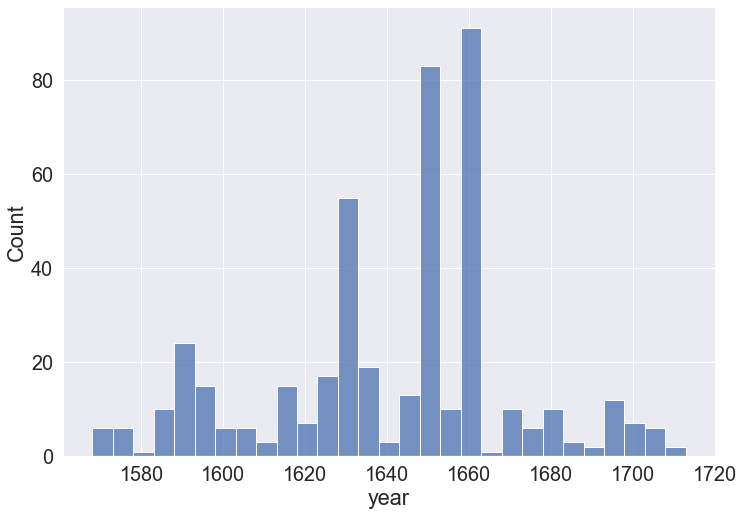

In [22]:
sns.set(font_scale=1.8)
ax = sns.histplot(data=df2['year'],binwidth=5)
plt.show()

The max came similarly around 1650, with a slightly different trend of growing during the first decades.

To do: Check whether there were any families or couples. Need to learn about the names: How many family names are normal? Does that mean the same family if (or only) the final names are the same? Has any division happened? Also, in terms of geography, any male cluster? 

### The Names

Anyway the names are definitely worth a look.

First, as usual, get a seperated dataframe to work with: 

In [23]:
df3 = df[['Name','Gender']]
df3

,Name,Gender
0,Jonnet McKennan,Female
1,Jonet Braidheid,Female
2,Wife of Soirle McAllexander,Female
3,Christian Watson,Female
4,Janet Conochie,Female
...,...,...
3149,Grissell Jaffray,Female
3150,Isobell Young,Female
3151,Margaret Burges,Female
3152,Margaret Fulton,Female


split the Name column in to parts seperated by blanks:

In [24]:
df3['split_names'] = df3['Name'].apply(lambda x:x.split(' '))
df3['split_names']

C:\Users\Lactose\AppData\Local\Temp\ipykernel_1732\506238152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['split_names'] = df3['Name'].apply(lambda x:x.split(' '))


0                     [Jonnet, McKennan]
1                     [Jonet, Braidheid]
2       [Wife, of, Soirle, McAllexander]
3                    [Christian, Watson]
4                      [Janet, Conochie]
                      ...               
3149                 [Grissell, Jaffray]
3150                    [Isobell, Young]
3151                  [Margaret, Burges]
3152                  [Margaret, Fulton]
3153                   [Agnes, Naismith]
Name: split_names, Length: 3154, dtype: object

Lovely, then we can take a look at names at the last and the first position:

In [25]:
df3['first_names'] = df3['split_names'].apply(lambda x:x[0])
df3['last_names'] = df3['split_names'].apply(lambda x:x[-1])
df3[['first_names','last_names']]

C:\Users\Lactose\AppData\Local\Temp\ipykernel_1732\3811863869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['first_names'] = df3['split_names'].apply(lambda x:x[0])
C:\Users\Lactose\AppData\Local\Temp\ipykernel_1732\3811863869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['last_names'] = df3['split_names'].apply(lambda x:x[-1])


,first_names,last_names
0,Jonnet,McKennan
1,Jonet,Braidheid
2,Wife,McAllexander
3,Christian,Watson
4,Janet,Conochie
...,...,...
3149,Grissell,Jaffray
3150,Isobell,Young
3151,Margaret,Burges
3152,Margaret,Fulton


In [26]:
df3['last_names'].value_counts()

Wilson      33
Anderson    25
Gray        24
Young       23
Stewart     22
            ..
Huttoun      1
Fernsche     1
Fren         1
Boswell      1
Fulton       1
Name: last_names, Length: 1760, dtype: int64

It seems not a few witches shared the same last name. However, it needs deeper study to explain this outcome.

In [27]:
df3['first_names'].value_counts()

Margaret    375
Jonet       195
Janet       192
Agnes       183
Bessie      129
           ... 
Marrion       1
Isable        1
Anny          1
Ewfame        1
Unknown       1
Name: first_names, Length: 406, dtype: int64

Also, Margaret was far ahead of other names. Furthermore, check the full names just in case:

In [28]:
df['Name'].value_counts()

Margaret Watson        5
Margaret Young         5
Margaret Wallace       5
Janet Anderson         4
Margaret Guthrie       4
                      ..
Elspeth Crystie        1
Jonet Wallace          1
Katherine King         1
Margaret Williamson    1
Agnes Naismith         1
Name: Name, Length: 2912, dtype: int64

So many witches of the same surname and given name! Is this a coincidence? Or some witches got caught multiple times? This is worth investigating, by checking the location(Long,Lat) can verify it in some ways.

## What's Next

- What was the relationship between witches and associated people?

- Were there any family business?

- Any cluster in the term of the geography?

- Parish choropleth, were they influencing witch hunting? 

- From residence location to detainment place, to place of death, any indication? Rights center? Execution ground? Concentration camp?
 